This notebook demonstrates how to perform readout error mitigation on a physical QPU using PennyLane-Forest. Readout error refers to the non-zero probability that a qubit's state may be read out as something other than the one that was actually sampled.<br>
<br>
For example, for a single qubit, we may sample some prepared state to produce the outcome `0` but actually read it out as a `1`. In conventional notation, the non-zero probability of such an event occuring is denoted by the conditional probability `p(1|0)`. More generally, we have non-zero probabilities `p(i|j)` of reading out `i` while having actually sampled `j`. On a perfect device, `p(0|0) = p(1|1) = 1`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from pennylane import numpy as np
import pennylane as qml

Specify the name of the QPU device below (make sure qubit 0 exists on this lattice).

In [2]:
device_name = 'Aspen-4-4Q-A'

Initialize two devices, one with the ability to carry out readout error mitigation and the other without.

In [3]:
# a device that does not carry out any read out error mitigation
dev_err = qml.device('forest.qpu', device=device_name,
                    symmetrize_readout=None, calibrate_readout=None)

# a device that carries out any read out error mitigation
dev_no_err = qml.device('forest.qpu', device=device_name)

Define a fairly simple circuit that calculates the expectation value $\langle 0 \vert\, RY^{\dagger}(\theta)\cdot Z \cdot RY(\theta) \, \vert 0 \rangle$.

In [4]:
def circuit(theta):
    qml.RX(theta, wires=0)
    return qml.expval(qml.PauliZ(0))

Create two different versions of this circuit, one that automatically carries out readout error mitigation and one that simply calculates the expectation value from the shots/measurements data it receives.

In [5]:
# circuit that gives results with readout errors
circuit_err = qml.QNode(circuit, dev_err)
# circuit that corrects for readout errors
circuit_no_err = qml.QNode(circuit, dev_no_err)

Define a helper function to calculate the ideal/exact results.

In [6]:
def ideal_result(theta):
    return np.square(np.cos(theta/2)) - np.square(np.sin(theta/2))

Calculate expectation values on both devices, while also calculating ideal results, for various values of theta.

In [7]:
angles = np.linspace(0.0, 2 * np.pi, 50)

err_Zs = []
no_err_Zs = []
ideal_results = []

for angle in angles:
    err_Zs.append(circuit_err(angle))
    no_err_Zs.append(circuit_no_err(angle))
    ideal_results.append(ideal_result(angle))

Using the above results, calculate the values of $(1 - \langle Z \rangle)\, / \,2$ for various values of $\theta$.

In [8]:
results_err = 0.5 * (1.0 - np.array(err_Zs))
results_no_err = 0.5 * (1.0 - np.array(no_err_Zs))
ideal_results = 0.5 * (1.0 - np.array(ideal_results))

Finally, plot all the results on the same figure.

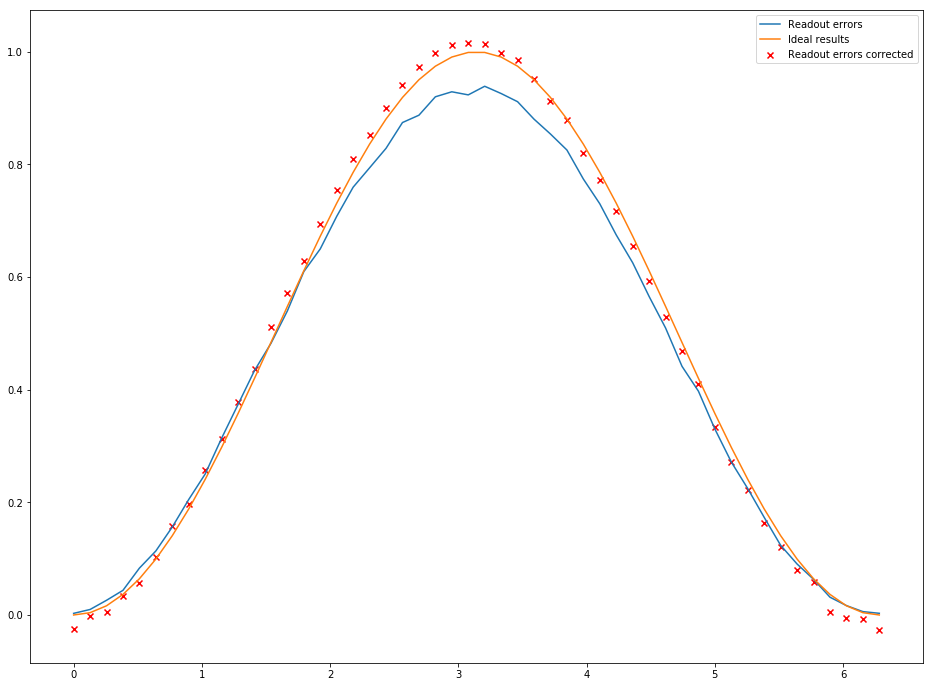

In [9]:
plt.figure(figsize=(16, 12))
plt.plot(angles, results_err, label='Readout errors')
plt.scatter(angles, results_no_err, marker='x', c='r', label='Readout errors corrected')
plt.plot(angles, ideal_results, label='Ideal results')
plt.legend(loc='best')
plt.show()

You should find that the results with readout error mitigation are closer to the ideal values than those without any correction/mitigation. In reality, there are other errors on the physical device beyond readout errors, but this technique helps us get better results for problems involving the calculation of expectation values of observables.